# Deep Pyramid Convolutional Neural Networks for Text Classification

<h3>Introduction</h3>

This notebook implements Deep Pyramid Convolutional Neural Networks (DPCNN) for Toxic Comment Classification Challenge on Kaggle. This model was a part of our final solution which was a stack of various models. Our team finished 15th overall amongst more than 4500 participants around the world and got a Gold medal!

<h3>Import Libraries</h3>

In [1]:
import sys
!{sys.executable} -m pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: pyyaml in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from keras)
You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os, sys
import re
import csv
import codecs
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.layers import concatenate, CuDNNGRU
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt

stopwords = set(stopwords.words("english"))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h3>Defining file paths and some basic configuration parameters</h3>

In [3]:
# Paths for running locally
# path = '..'
# EMBEDDING_FILE=path+'/input/glove.840B.300d.txt'
# EMBEDDING_FILE=path+'/input/crawl-300d-2M.vec'
# TRAIN_DATA_FILE=path+'/input/train.csv'
# TEST_DATA_FILE=path+'/input/test.csv'

# paths for running on cloud
EMBEDDING_FILE='/public/models/glove/glove.840B.300d.txt'
TRAIN_DATA_FILE='/public/toxic_comments/train.csv'
TEST_DATA_FILE='/public/toxic_comments/test.csv'

MAX_SEQUENCE_LENGTH = 200
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

filter_nr = 64
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.4
dense_dropout = 0.4

<h3>Defining some functions for text processing and cleaning</h3>

In [4]:
def cleanData(text, stemming=False, lemmatize=False):    
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in text.split()])
    if lemmatize:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w) for w in text.split()])
    return text

special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    text = text.lower().split()
    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    #Remove Special Characters
    text=special_character_removal.sub('',text)
    #Replace Numbers
    text=replace_numbers.sub('n',text)
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    return(text)

<h3>Read Training and Testing Data</h3>

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.
<ul><li>toxic</li><li>severe_toxic</li><li>obscene</li><li>threat</li><li>insult</li><li>identity_hate</li></ul>


In [5]:
train_df = pd.read_csv(TRAIN_DATA_FILE)
test_df = pd.read_csv(TEST_DATA_FILE)

print('Processing text dataset')

train_df['comment_text'] = train_df['comment_text'].map(lambda x: cleanData(x, stemming=False, lemmatize=False))
test_df['comment_text'] = test_df['comment_text'].map(lambda x: cleanData(x, stemming=False, lemmatize=False))
print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape) 

Processing text dataset
Train shape:  (159571, 8)
Test shape:  (153164, 2)


<h3>Train Set</h3>

In [6]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww ! he matches this background colour i am...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


<h3>Test Set</h3>

In [7]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,= = from rfc = = the title is fine as it is imo
2,00013b17ad220c46,= = sources = = zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the inf...
4,00017695ad8997eb,i do not anonymously edit articles at all


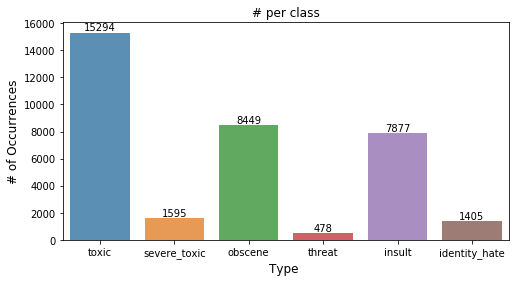

In [8]:
x = train_df.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<h3>Correlation between output classes</h3>

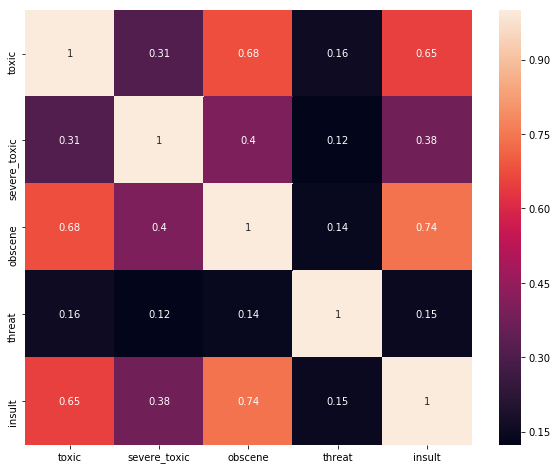

In [9]:
temp_df = train_df.iloc[:,2:-1]
corr = temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

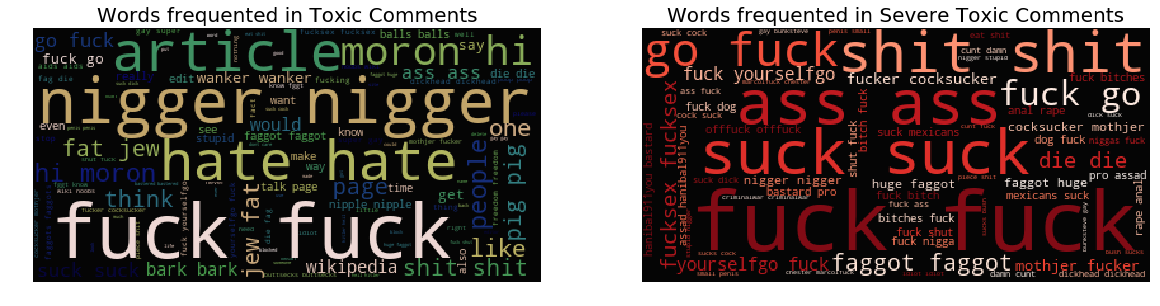

In [10]:
from wordcloud import WordCloud ,STOPWORDS

subset = train_df[train_df.toxic==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=4000, stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth', random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
subset = train_df[train_df.severe_toxic==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds', random_state=244), alpha=0.98)
plt.show()

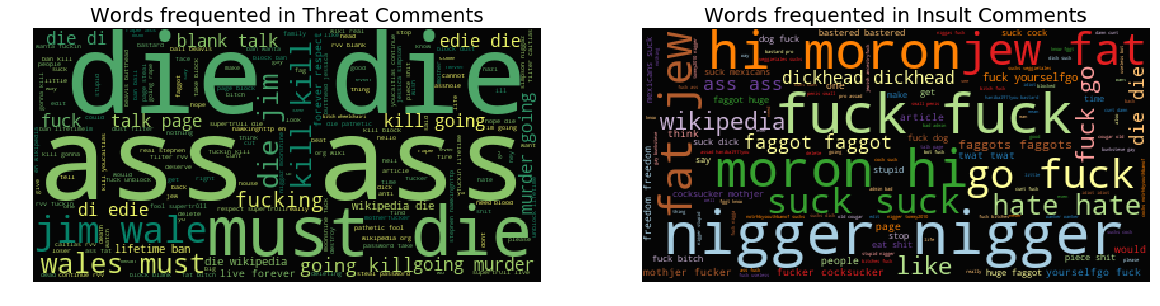

In [11]:
#Threat comments
plt.figure(figsize=(20,20))
plt.subplot(221)
subset = train_df[train_df.threat==1]
text = subset.comment_text.values
wc= WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threat Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer', random_state=2534), alpha=0.98)

#insult
plt.subplot(222)
subset = train_df[train_df.insult==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r', random_state=244), alpha=0.98)
plt.show()

<h3>Preprocessing and Tokenizing</h3>

Filling missing values and Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [12]:
list_sentences_train = train_df["comment_text"].fillna("NA").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
list_sentences_test = test_df["comment_text"].fillna("NA").values

comments = []
for text in list_sentences_train:
    comments.append(text_to_wordlist(text))
    
test_comments=[]
for text in list_sentences_test:
    test_comments.append(text_to_wordlist(text))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments + test_comments)

sequences = tokenizer.texts_to_sequences(comments)
test_sequences = tokenizer.texts_to_sequences(test_comments)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data_post = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of pre train data tensor:', data.shape)
print('Shape of post train data tensor:', data_post.shape)
print('Shape of output label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of pre test data tensor:', test_data.shape)
test_data_post = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print('Shape of post test data tensor:', test_data_post.shape)

Found 292462 unique tokens
Shape of pre train data tensor: (159571, 200)
Shape of post train data tensor: (159571, 200)
Shape of output label tensor: (159571, 6)
Shape of pre test data tensor: (153164, 200)
Shape of post test data tensor: (153164, 200)


<h3>Glove Vectors</h3>

Read the glove word vectors (space delimited strings) into a dictionary from word->vector

In [13]:
print('Indexing word vectors')

count = 0
embeddings_index = {}
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = ' '.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs.reshape(-1)
    coef = embeddings_index[word]
f.close()

print('Found %d word vectors of glove.' % len(embeddings_index))
emb_mean, emb_std = coef.mean(), coef.std()
print(emb_mean, emb_std)

print('Total %s word vectors.' % len(embeddings_index))

Indexing word vectors
Found 2195895 word vectors of glove.
-0.01444638 0.47249147
Total 2195895 word vectors.


Use these vectors to create embedding matrix

In [14]:
print('Preparing embedding matrix')
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 21603


# DPCNN Model

The model consists of four convolutional blocks with each block consisting of two Concolution layers with 64 filters of size = 3 followed by a short-cut connection and a max-pooling layer with size = 3 and stride = 2.
A dropout of 0.4 is added to the network to prevent overfitting.

<h3>Features of DPCNN Architecture</h3>

<ul><li>Downsampling without increasing the number of feature maps - Downsampling enables efficient representation of long range associations (and so more global information) in the text. By keeping the same number of feature maps, every 2-stride downsampling reduces the per-block computation by half and thus the total computation time is bounded by a constant.</li><li>Shortcut connections with pre-activation and identity mapping</li><ul>

In [15]:
from keras.optimizers import Adam
from keras.layers import concatenate

def get_model():
    
    inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    inp_post = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    emb_comment1 = Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix],trainable=False)(inp)
    emb_comment1 = SpatialDropout1D(spatial_dropout)(emb_comment1)

    block11 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(emb_comment1)
    block11 = BatchNormalization()(block11)
    block11 = PReLU()(block11)
    block11 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block11)
    block11 = BatchNormalization()(block11)
    block11 = PReLU()(block11)

    resize_emb1 = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear')(emb_comment1)
    resize_emb1 = PReLU()(resize_emb1)

    block1_output1 = add([block11, resize_emb1])
    block1_output1 = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output1)

    block21 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block1_output1)
    block21 = BatchNormalization()(block21)
    block21 = PReLU()(block21)
    block21 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block21)
    block21 = BatchNormalization()(block21)
    block21 = PReLU()(block21)

    block2_output1 = add([block21, block1_output1])
    block2_output1 = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output1)

    block31 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block2_output1)
    block31 = BatchNormalization()(block31)
    block31 = PReLU()(block31)
    block31 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block31)
    block31 = BatchNormalization()(block31)
    block31 = PReLU()(block31)

    block3_output1 = add([block31, block2_output1])
    block3_output1 = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output1)

    block41 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block3_output1)
    block41 = BatchNormalization()(block41)
    block41 = PReLU()(block41)
    block41 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block41)
    block41 = BatchNormalization()(block41)
    block41 = PReLU()(block41)

    output1 = add([block41, block3_output1])
    output1 = GlobalMaxPooling1D()(output1)
    
    
    
    emb_comment2 = Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inp_post)
    emb_comment2 = SpatialDropout1D(spatial_dropout)(emb_comment2)

    block12 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(emb_comment2)
    block12 = BatchNormalization()(block12)
    block12 = PReLU()(block12)
    block12 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block12)
    block12 = BatchNormalization()(block12)
    block12 = PReLU()(block12)

    resize_emb2 = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear')(emb_comment2)
    resize_emb2 = PReLU()(resize_emb2)

    block1_output2 = add([block12, resize_emb2])
    block1_output2 = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output2)

    block22 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block1_output2)
    block22 = BatchNormalization()(block22)
    block22 = PReLU()(block22)
    block22 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block22)
    block22 = BatchNormalization()(block22)
    block22 = PReLU()(block22)

    block2_output2 = add([block22, block1_output2])
    block2_output2 = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output2)

    block32 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block2_output2)
    block32 = BatchNormalization()(block32)
    block32 = PReLU()(block32)
    block32 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block32)
    block32 = BatchNormalization()(block32)
    block32 = PReLU()(block32)

    block3_output2 = add([block32, block2_output2])
    block3_output2 = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output2)

    block42 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block3_output2)
    block42 = BatchNormalization()(block42)
    block42 = PReLU()(block42)
    block42 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear')(block42)
    block42 = BatchNormalization()(block42)
    block42 = PReLU()(block42)

    output2 = add([block42, block3_output2])
    output2 = GlobalMaxPooling1D()(output2)

            
    output = concatenate([output1, output2])
    output = Dense(dense_nr, activation='linear')(output)
    output = BatchNormalization()(output)
    output = PReLU()(output)
    output = Dropout(dense_dropout)(output)
    output = Dense(6, activation='sigmoid')(output)
   
    model = Model(inputs=[inp, inp_post], outputs=output, name="DPCNN")
    model.compile(loss='binary_crossentropy',
    optimizer=Adam(lr=1e-3,decay=0),
    metrics=['accuracy'])

    return model

<h3>Model Summary</h3>
<ul><li>Optimizer: Adam</li><li>Learning Rate: 0.001</li><li>Batch Size: 128</li></ul>

In [17]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 300)     30000000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dr

<h3>Training the model</h3>

<h4>With 10-fold cross-validation</h4>

In [16]:
test_predicts_list = []

def train_folds(data, data_post, y, fold_count, batch_size):
    print("Starting to train models...")
    fold_size = len(data) // fold_count
    models = []
    for fold_id in range(0, fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size

        if fold_id == fold_size - 1:
            fold_end = len(data)

        print("Fold {0}".format(fold_id))
        
        train_x = np.concatenate([data[:fold_start], data[fold_end:]])
        train_xp = np.concatenate([data_post[:fold_start], data_post[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])

        val_x = data[fold_start:fold_end]
        val_xp = data_post[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
        
        file_path = "dpcnn_fold{0}.h5".format(fold_id)
        model = get_model()
        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, 
                                     mode='min')
        early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
        callbacks_list = [checkpoint, early] 

        hist = model.fit([train_x, train_xp], train_y, epochs=15, batch_size=128, shuffle=True, 
                         validation_data=([val_x, val_xp], val_y), callbacks = callbacks_list, verbose=1)
        model.load_weights(file_path)
        best_score = min(hist.history['val_loss'])
        
        print("Fold {0} loss {1}".format(fold_id, best_score))
        print("Predicting validation...")
        val_predicts_path = "dpcnn_val_predicts{0}.npy".format(fold_id)
        val_predicts = model.predict([val_x, val_xp], batch_size=1024, verbose=1)
        np.save(val_predicts_path, val_predicts)
        
        print("Predicting results...")
        test_predicts_path = "dpcnn_test_predicts{0}.npy".format(fold_id)
        test_predicts = model.predict([test_data, test_data_post], batch_size=1024, verbose=1)
        test_predicts_list.append(test_predicts)
        np.save(test_predicts_path, test_predicts)
        
# train_folds(data, data_post, y, 10, 128)

<h4>With single train-validation split</h4>

In [19]:
def train(data, data_post, y, batch_size):
    print("Starting to train model...")
    file_path = "dpcnn.h5"
    model = get_model()
    checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, 
                                 mode='min')
    early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
    callbacks_list = [checkpoint, early] 

    hist = model.fit([data, data_post], y, epochs=15, batch_size=128, shuffle=True, validation_split=0.1, 
                     callbacks = callbacks_list, verbose=1)
    model.load_weights(file_path)
    best_score = min(hist.history['val_loss'])
        
    print("Final Validation Loss {}".format(best_score))
        
    print("Predicting results...")
    test_predicts_path = "dpcnn_test_predicts.npy"
    test_pred = model.predict([test_data, test_data_post], batch_size=1024, verbose=1)
    np.save(test_predicts_path, test_pred)
        
train(data, data_post, y, 128)

Starting to train model...
Train on 143613 samples, validate on 15958 samples
Epoch 1/15
143613/143613 [==============================] - 130s 905us/step - loss: 0.0683 - acc: 0.9758 - val_loss: 0.0484 - val_acc: 0.9817

Epoch 00001: val_loss improved from inf to 0.04844, saving model to dpcnn.h5
Epoch 2/15
143613/143613 [==============================] - 124s 865us/step - loss: 0.0473 - acc: 0.9822 - val_loss: 0.0443 - val_acc: 0.9831

Epoch 00002: val_loss improved from 0.04844 to 0.04426, saving model to dpcnn.h5
Epoch 3/15
143613/143613 [==============================] - 124s 864us/step - loss: 0.0441 - acc: 0.9831 - val_loss: 0.0437 - val_acc: 0.9833

Epoch 00003: val_loss improved from 0.04426 to 0.04366, saving model to dpcnn.h5
Epoch 4/15
143613/143613 [==============================] - 124s 865us/step - loss: 0.0419 - acc: 0.9835 - val_loss: 0.0431 - val_acc: 0.9832

Epoch 00004: val_loss improved from 0.04366 to 0.04314, saving model to dpcnn.h5
Epoch 5/15
143613/143613 [====

<h3>Predicting for test data and saving results</h3>

<h4>With 10-fold cross-validation - Arithmetic Mean</h4>

In [20]:
CLASSES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

test_predicts_am = np.zeros(test_predicts_list[0].shape)

for fold_predict in test_predicts_list:
    test_predicts_am += fold_predict

test_predicts_am = (test_predicts_am / len(test_predicts_list))

test_ids = test_df["id"].values
test_ids = test_ids.reshape((len(test_ids), 1))

test_predicts_am = pd.DataFrame(data=test_predicts_am, columns=CLASSES)
test_predicts_am["id"] = test_ids
test_predicts_am = test_predicts_am[["id"] + CLASSES]
test_predicts_am.to_csv("10fold_dpcnn_test.csv", index=False)

<h4>With single train-validation split</h4>

In [21]:
CLASSES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

test_ids = test_df["id"].values
test_ids = test_ids.reshape((len(test_ids), 1))

test_pred = np.load('dpcnn_test_predicts.npy')
test_pred_df = pd.DataFrame(data=test_pred, columns=CLASSES)
test_pred_df["id"] = test_ids
test_pred_df = test_pred_df[["id"] + CLASSES]
test_pred_df.to_csv("dpcnn_test.csv", index=False)

<h3>End</h3>